## CSCI E-116 Final Term Project
### Short-Term Prediction of Retail Store Sales Using Time Series Models
#### Data File: storesalesdaily20221127EN.xlsx
__ __
### Roger Zeng
_December 16th, 2022_

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
    
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR
from pykalman import KalmanFilter
from prophet import Prophet

In [68]:
# define forecasting methods
def rolling_average(data):
    # calculate rolling average and forecast sales
    return data.rolling(window=4).mean().shift()

def exponential_smoothing(data):
    # fit exponential smoothing model and forecast sales
    model = ExponentialSmoothing(data)
    model_fit = model.fit()
    forecast = model_fit.forecast(2)
    return forecast

def arima(data):
    # fit ARIMA model and forecast sales
    # use p,d,q as determined by AutoARIMA()
    pdq = auto_arima(data, error_action='ignore')
    print(f'the AUTO order is {pdq.order}')
    model = ARIMA(data, order=pdq.order).fit()
    # Make a forecast for the next 2 time periods
    return model.forecast(steps=2).tail(2)

def prophet(data):
    data.columns = ['ds', 'y']
    pm = Prophet(interval_width=0.9,  # 90% C.I. or is it?
                           yearly_seasonality=True, 
                           weekly_seasonality=True, 
                           changepoint_prior_scale=0.08,
                           changepoint_range=0.9)
    pm.add_country_holidays(country_name='CN')
    pm.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=1)
    pm.add_seasonality(name='yearly', period=365, fourier_order=10, prior_scale=1)

    #Fit model
    pm.fit(data)
    
    future = pm.make_future_dataframe(periods=2, freq='W')
    forecast = pm.predict(future)
    
    forecast = forecast.tail(2)
    
    return forecast[['ds','yhat']]

In [3]:
def CleanTransform(dirtyDf):
    '''
    General data cleansing and transformation including
        - Fill NA values
        - Remove subtotals and other redundant information
        - Pivot StockID to columns
        - Resample to weekly data
    '''
    dirtyDf['Date'].fillna(method="ffill", inplace=True)
    cleanDf = dirtyDf.dropna(subset=['StockID'])
    cleanDf = dirtyDf.loc[dirtyDf['StockID'] != 'Patagonia Sticker']
    
    dateIndex = pd.to_datetime(cleanDf['Date'], format='%Y-%m-%d') 
    cleanDf = cleanDf.assign(date=pd.Series(dateIndex, dtype='datetime64'))
    
    # transform into multivariate time series 
    data = cleanDf.pivot(index='date', columns='StockID', values='QTY')
    dataW = data.resample('W').sum()

    return dataW

In [69]:
class StoreForecast:  
    def __init__(self, storeID, methods, weeklySales=None, rollingAvg= None, 
                 forecasts={}, mape={}, optimalForecast={}):
        self.storeID = storeID
        self.methods = methods
        self.weeklySales = weeklySales
        self.rollingAvg = rollingAvg
        self.forecasts = forecasts
        self.mape = mape
        self.optimalForecast = optimalForecast
        
    def get_store_id(self):
        return self.storeID
    
    def update_sales_history(self, data):
        self.weeklySales = data
        # change zero weeklies to avoid devide by zero for MAPE
        self.weeklySales.iloc[:,0].replace(0, 1, inplace=True)
    
    def get_sales_history(self):
        return self.weeklySales
    
    def update_rolling_avg(self):
        self.rollingAvg = rolling_average(self.weeklySales.iloc[:,0])
    
    def get_rolling_avg(self):
        return self.rollingAvg
 
    def update_forecasts(self):
        X_actual = self.weeklySales.iloc[:, 1:]
        y_actual = self.weeklySales.iloc[:, 0]

        X_train, X_test = X_actual.iloc[:-2,], X_actual.iloc[-2:,]
        y_train, y_test = y_actual.iloc[:-2], y_actual.iloc[-2:]
        
        # Exponential smoothing forecasts
        self.forecasts.update({methods[0]: exponential_smoothing(y_train)})
        
        # ARIMA forecasts
        self.forecasts.update({methods[1]: arima(y_train)})
        
        # Prophet forecast     
        # Wow! prophet returned data so twisted, it needs all these acrobatics just to be used!
        pf = prophet(y_train.reset_index()).reset_index(drop=True).set_index("ds")
        prophetForecast = pf.iloc[:,0]
        self.forecasts.update({methods[2]: prophetForecast})
        #self.forecasts.update({methods[3]: vector_autoregression(self.weeklySales)})
        #self.forecasts.update({methods[4]: kalman_filter(self.weeklySales.iloc[:,0])})
        
        # Plot all forecasts vs Actual
        plt.figure(figsize=(15,10))
        
        plt.plot(y_actual.tail(26), label='Ground Truth')
        plt.plot(self.rollingAvg.tail(26), label='4-week Roll Avg')
        plt.plot(self.forecasts[methods[0]], label=methods[0])
        plt.plot(self.forecasts[methods[1]], label=methods[1])
        plt.plot(self.forecasts[methods[2]], label=methods[2])
        #plt.plot(self.forecasts[methods[3]], label=methods[3])
        #plt.plot(self.forecasts[methods[4]], label=methods[4])

        plt.axvspan(y_test.index[0], y_test.index[-1], facecolor='black', alpha=0.2)        
        plt.title('6-Month Actual and 2 Week Forecasts', color='green')
        plt.tick_params(axis='x', colors='green')    #setting up X-axis tick color to red
        plt.tick_params(axis='y', colors='green')    #setting up X-axis tick color to red
        plt.legend(loc=1)
        plt.show()

    def get_forecasts(self):
        return self.forecasts
    
    def update_mape(self):
        y_actual = self.weeklySales.iloc[-2:, 0]

        for x in methods:
            '''
            print(f"MAPE for {x}")
            print(f"{self.forecasts[x]}")
            print(type(self.forecasts[x]))
            '''
            mapeVector = abs(self.forecasts[x]-y_actual)/y_actual
            #print(f"MAPE Vector\n {mapeVector}")
            mape = np.mean(mapeVector)
            self.mape.update({x: mape})
        
    def get_mape(self):
        return self.mape
    
    def get_optimal_forecast(self):
        # Use rolling average as base case
        rollAvgVec = abs(self.weeklySales.iloc[-2:, 0] - self.rollingAvg[-2:])/self.weeklySales.iloc[-2:, 0]
        optimal_mape = np.mean(rollAvgVec)
        optimal_method = 'rolling_average'
        
        min_mape = min(self.mape.values())
        if min_mape < optimal_mape:
            optimal_method = [i for i in self.mape if self.mape[i] == min_mape]
            optimal_mape = min_mape

        return optimal_method, optimal_mape

In [5]:
# load daily store total sales
storeNames = ['KerryCenter', 'Sanlitun', 'Hangda']

# Load daily sales data and set the index to a datetime column
dailyTTL = pd.read_excel("storesalesdaily20221127EN.xlsx", header=0, parse_dates=True, index_col='Date')
dailyTTL.drop(['Yansha', 'Taobao', 'Bicester'], axis=1, inplace=True)

In [6]:
# load itemized sales of each store
dailyItemized = [pd.read_excel("storesalesdaily20221127EN.xlsx", sheet_name=x, 
                          skiprows=2, header=0, skipfooter=1, parse_dates=True) for x in storeNames ]

weeklyItemized = [CleanTransform(x) for x in dailyItemized]

In [7]:
# load ecom data, which is in a different format
colnames = ['Date', 'StockID', 'QTY', 'AMT']
dtmall = pd.DataFrame(columns=colnames)
ecomcols = {0: "A:D", 1: "G:J", 2: "M:P", 3: "S:V"}

for i, cols in ecomcols.items():
    tmpdf = pd.read_excel("storesalesdaily20221127EN.xlsx", sheet_name='TMall', usecols=cols,
                              skiprows=2, header=0, parse_dates=True).dropna(how='all')
    tmpdf.columns = colnames
    lastRow = tmpdf.index[-1]  
    tmpdf.drop(lastRow, inplace=True)  # delete '总计' row 
    dtmall = pd.concat([dtmall, tmpdf])  # paste four years together

In [8]:
# Post processing ecom data and add the clean ecom data together with the other stores
weeklyItemized.append(CleanTransform(dtmall))

# reflect the addition in the store list 
storeNames.append('TMall')

the AUTO order is (1, 1, 2)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


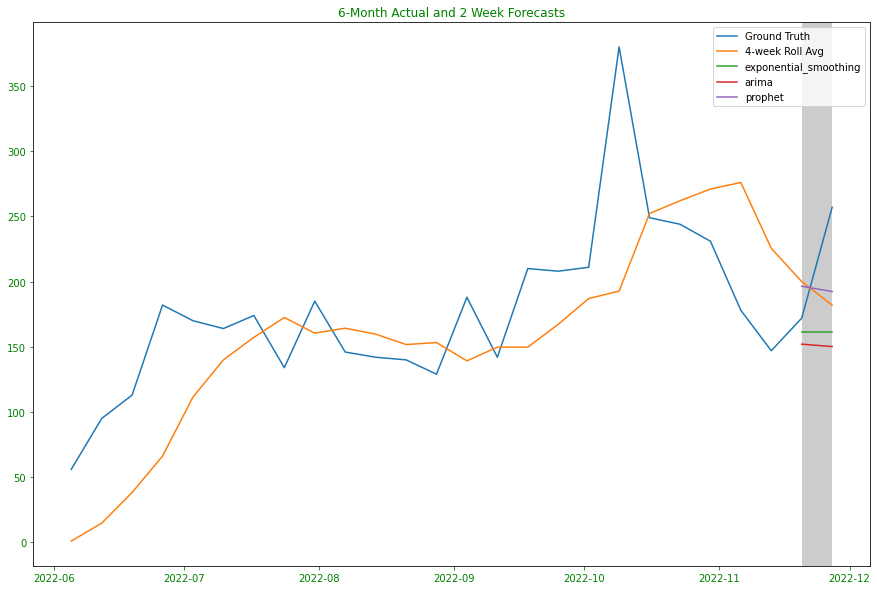

Optimal forecast method for KerryCenter is ['prophet'] at 19.7% MAPE
the AUTO order is (1, 1, 1)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


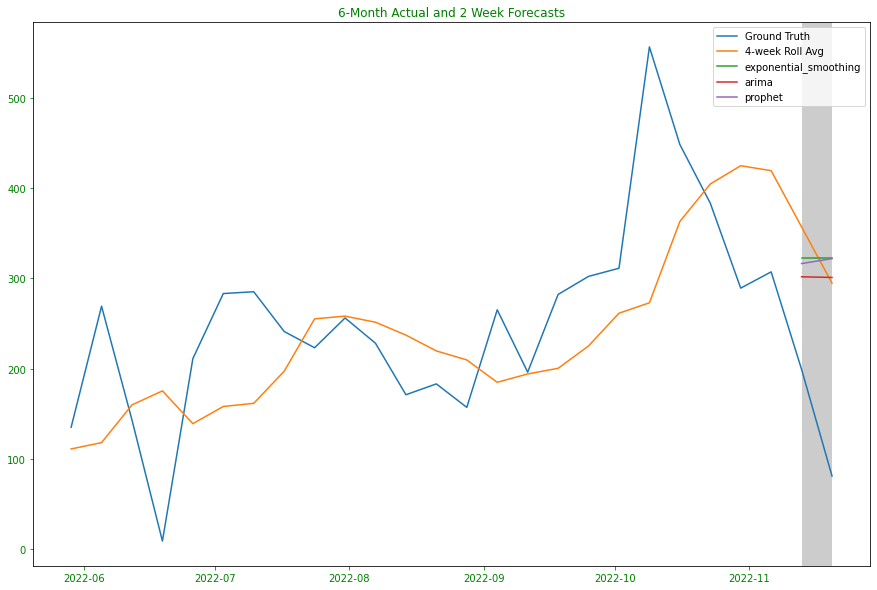

Optimal forecast method for Sanlitun is ['arima'] at 161.5% MAPE
the AUTO order is (1, 1, 1)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


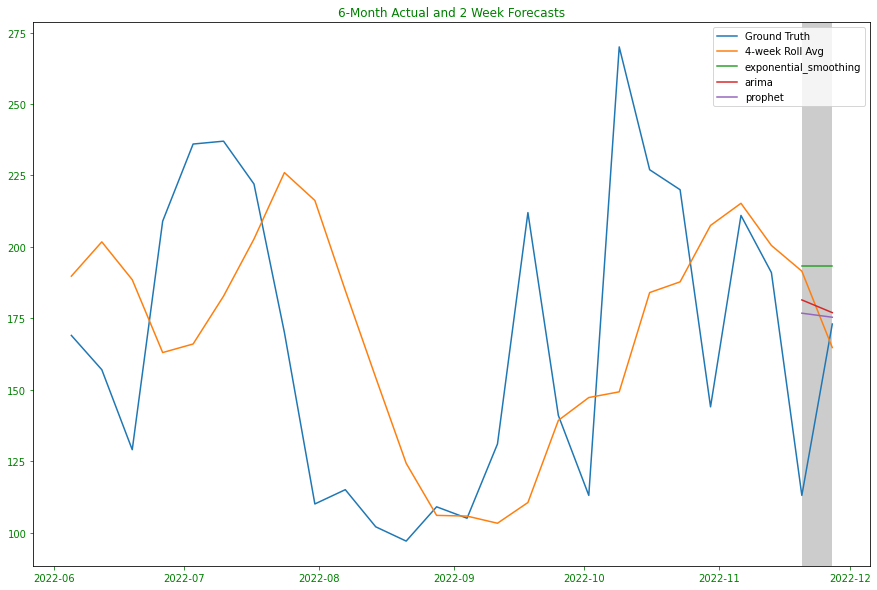

Optimal forecast method for Hangda is ['prophet'] at 28.9% MAPE
the AUTO order is (4, 1, 1)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


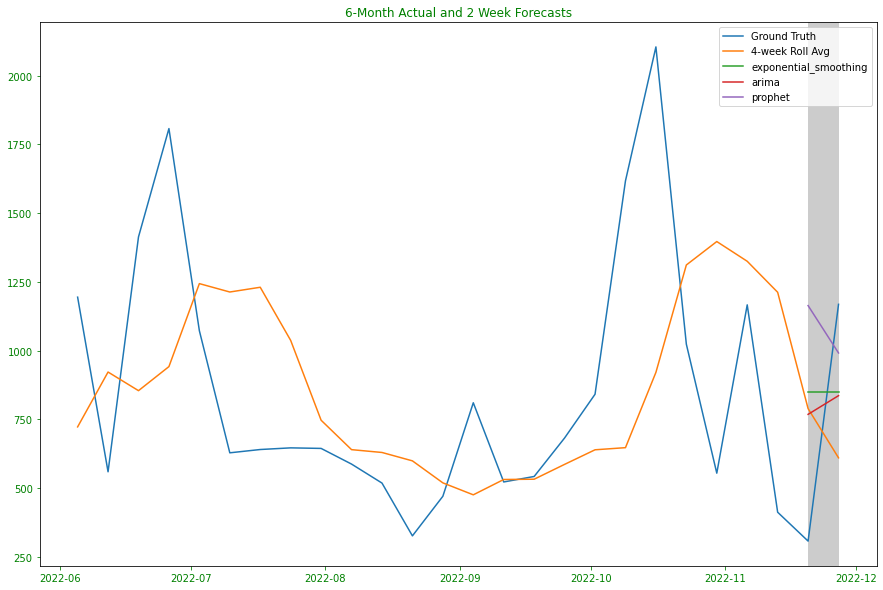

Optimal forecast method for TMall is ['arima'] at 89.3% MAPE


In [70]:
# list of forecast methods to evaluate
#methods = ['exponential_smoothing', 'arima', 'prophet', 'vector_autoregression', 'kalman_filter']
methods = ['exponential_smoothing', 'arima', 'prophet']

# Instantiate class objects and calculate properties
forecasts = {x: StoreForecast(x, methods) for x in storeNames}

for i, x in enumerate(storeNames):
    forecasts[x].update_sales_history(weeklyItemized[i])
    forecasts[x].update_rolling_avg()
    forecasts[x].update_forecasts()
    forecasts[x].update_mape()
    opti_meth, opti_mape = forecasts[x].get_optimal_forecast()
    print(f"Optimal forecast method for {x} is {opti_meth} at {opti_mape*100:.1f}% MAPE")

ADF Statistic
 -2.751 
 p-value = 0.0657
 num of lags = 1
ADF Statistic
 -3.950 
 p-value = 0.0017
 num of lags = 3
ADF Statistic
 -3.190 
 p-value = 0.0206
 num of lags = 2
ADF Statistic
 -4.536 
 p-value = 0.0002
 num of lags = 3


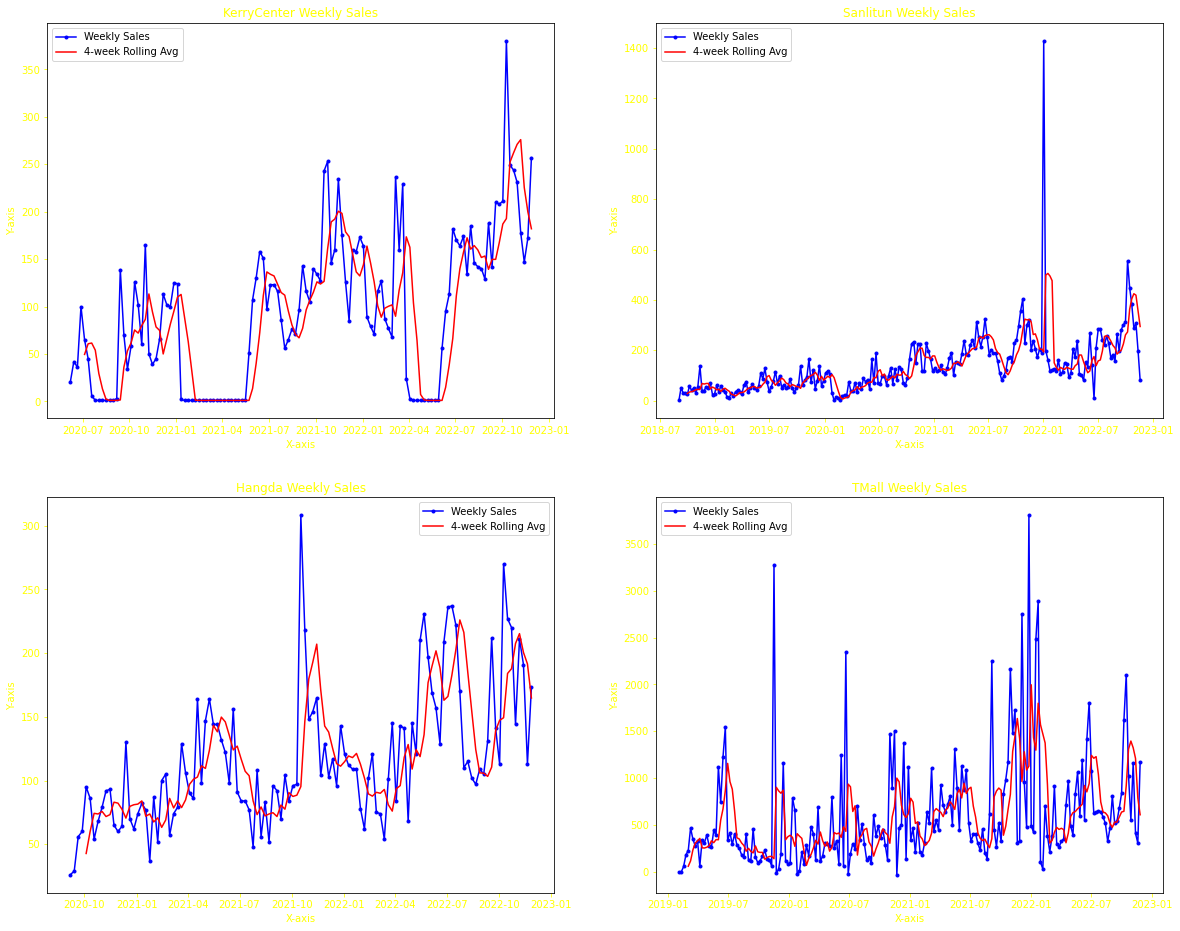

In [64]:
# Plot weekly data
# create figure and subplots
fig, ax = plt.subplots(2, 2, figsize=(20,16))

# iterate over retail stores
for i, x in enumerate(forecasts):
    # 4 week rolling average as baseline prediction
    # plot sales data on corresponding subplot
    row = i // 2
    col = i % 2   
    ax[row][col].plot(forecasts[x].weeklySales.iloc[:,0], "b.-", label='Weekly Sales')
    ax[row][col].plot(forecasts[x].get_rolling_avg(), "r-", label='4-week Rolling Avg')
    ax[row][col].set_title(storeNames[i]+" Weekly Sales", color='yellow')
    
    adf_test = adfuller(forecasts[x].weeklySales.iloc[:,0], autolag = 'AIC')
    print(f"ADF Statistic\n {adf_test[0]:.3f} \n p-value = {adf_test[1]:.4f}\n num of lags = {adf_test[2]}")

    
for a in ax.flatten():
    a.legend()
    a.tick_params(axis='x', colors='yellow')
    a.tick_params(axis='y', colors='yellow')
    a.set_xlabel('X-axis', color='yellow')
    a.set_ylabel('Y-axis', color='yellow')
    
# show plot
plt.show()